Goals
1. Make code to determine 1D chain phonon bands
2. Make code for diatomic 1D chain phonon bands
3. Expand to 2D systems
4. Create as class object and allowing editing of values
5. Implement pyqula lattice layouts
6. Expand to 3D calculations

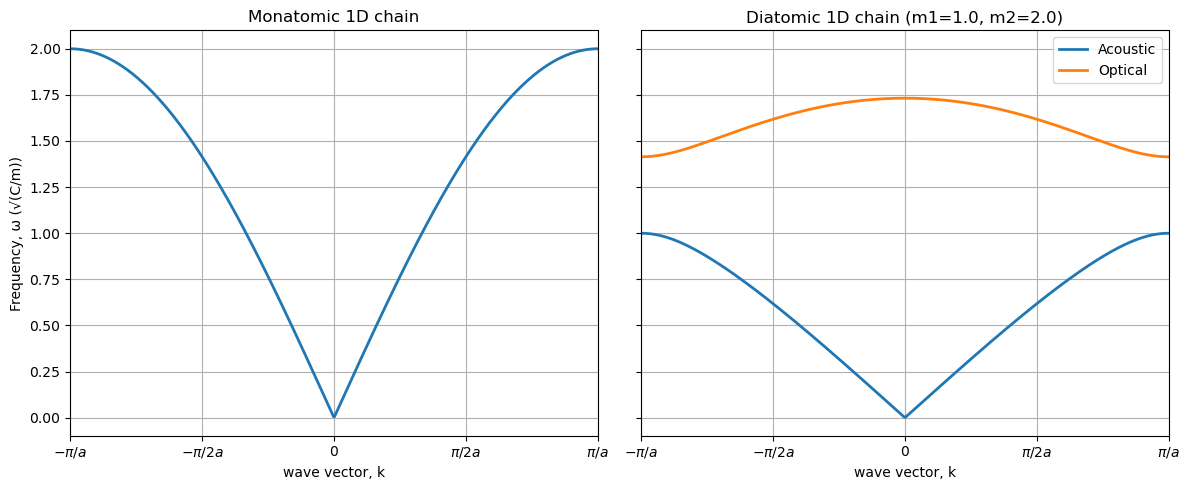

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def dispersion_monatomic(k, m=1.0, C=1.0, a=1.0):
    """
    Monatomic chain dispersion:
        omega(k) = 2 * sqrt(C/m) * |sin(k*a/2)|
    """
    omega = 2.0 * np.sqrt(C / m) * np.abs(np.sin(k * a / 2.0))
    return omega

def dispersion_diatomic(k, m1=1.0, m2=2.0, C=1.0, a=1.0):
    """
    Diatomic chain dispersion:

      omega^2 = C*(m1+m2)/(m1*m2) * [ 1 ± sqrt( 1 - gamma*sin^2(ka/2) ) ]

    where gamma = 4*m1*m2 / (m1+m2)^2
    """
    s = np.sin(k * a / 2.0)

    A = (m1 + m2) / (m1 * m2)
    gamma = 4.0 * m1 * m2 / (m1 + m2)**2

    inside_sqrt = 1.0 - gamma * s**2
    inside_sqrt = np.maximum(inside_sqrt, 0.0)   
    root = np.sqrt(inside_sqrt)

    omega_sq_plus  = C * A * (1.0 + root)
    omega_sq_minus = C * A * (1.0 - root)

    omega_plus  = np.sqrt(np.maximum(omega_sq_plus, 0.0))
    omega_minus = np.sqrt(np.maximum(omega_sq_minus, 0.0))

    return omega_minus, omega_plus   # acoustic, optical


def plot_phonon_branches(num_k=400, a=1.0,
                         monatomic_params=(1.0, 1.0),      # (m, C)
                         diatomic_params=(1.0, 2.0, 1.0)):  # (m1, m2, C)
                         
    # k from -π/a to +π/a (1st BZ)
    k = np.linspace(-np.pi / a, np.pi / a, num_k)

    m, C = monatomic_params
    m1, m2, C_dia = diatomic_params

    w_mono = dispersion_monatomic(k, m=m, C=C, a=a)
    w_dia_ac, w_dia_op = dispersion_diatomic(k, m1=m1, m2=m2, C=C_dia, a=a)

    unit = "√(C/m)"

    fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

    # Monatomic
    ax = axes[0]
    ax.plot(k * a, w_mono, lw=2)
    ax.set_title("Monatomic 1D chain")
    ax.set_xlabel("wave vector, k")
    ax.set_ylabel(f"Frequency, ω ({unit})")
    #Plotting only within the first Brillouin Zone
    ax.set_xlim(-np.pi/a, np.pi/a)
    ax.set_xticks([-np.pi/a, -np.pi/(2*a), 0, np.pi/(2*a), np.pi/a])
    ax.set_xticklabels([r"$-\pi/a$", r"$-\pi/2a$", "0", r"$\pi/2a$", r"$\pi/a$"])

    ax.grid(True)

    # Diatomic
    ax = axes[1]
    ax.plot(k * a, w_dia_ac, lw=2, label="Acoustic")
    ax.plot(k * a, w_dia_op, lw=2, label="Optical")
    ax.set_title(f"Diatomic 1D chain (m1={m1}, m2={m2})")
    ax.set_xlabel("wave vector, k")
    ax.set_xlim(-np.pi/a, np.pi/a)
    ax.set_xticks([-np.pi/a, -np.pi/(2*a), 0, np.pi/(2*a), np.pi/a])
    ax.set_xticklabels([r"$-\pi/a$", r"$-\pi/2a$", "0", r"$\pi/2a$", r"$\pi/a$"])
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_phonon_branches(
        num_k=600,
        a=1.0,
        monatomic_params=(1.0, 1.0),      # m, C
        diatomic_params=(1.0, 2.0, 1.0))  # m1, m2, C


- Expand on 1D chain to have N atomic masses
- Plot vibrational modes for multiatomic interactions without periodicity F=m1a=-km1(x1-x2), F=m2a=-km2(x2-x1)
- Github page for updates

Workflow for N-atomic function
- Define the number of different atoms and their masses
- Create a matrix based on calculated parameters
- solve determinant
- plot w vs k

In [3]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def N_atomic_symbolic():
    '''
    Creates an array for 1D chain of N variety atoms and their forces. 
    Array determinant then found to calculate the phonon dispersion.
    '''
        
    # Asks user how many different atoms are in the chain and varifies it is a valid integer
    while True:
        N_input = input("How many atoms in the chain? ")
        # Check empty input
        if N_input.strip() == "":
            print("Error: Please enter a value.")
            continue
        # Check integer validity
        try:
            N = int(N_input)
            if N <= 0:
                print("Error: Number of atoms must be a positive integer.")
                continue
            break
        except ValueError:
            print("Error: Please enter a valid integer.")
            continue
    
    
    masses = [] # Creates a list for all the masses to be used
    
    for atom in range(N): # Takes user input of mass for each atom and adds to list of masses while checking it is a valid mass
        while True:
            mass_input = input(f"What is the mass of atom {atom + 1}? ")
            # Empty check
            if mass_input.strip() == "":
                print("Error: Please enter a value.")
                continue
            # Numeric check
            try:
                mass = float(mass_input)
                break
            except ValueError:
                print("Error: Mass must be a valid number (integer or decimal).")
                continue
        masses.append(mass)
    
    print(f"The atomic masses are {masses}")
    
    # symbolic variables
    omega = sp.symbols('omega')
    C, k, a = sp.symbols('C k a')
    
    forces_matrix = sp.MutableDenseMatrix(N, N, lambda i, j: 0) # Creates an NxN matrix of all zeroes using SymPy
    print(forces_matrix)
    
    # Replaces the values at the top right and bottom left indices with the values consistent in calculation using SymPy notation
    # Requires N-1 as matrices use row x column with 0 index notation ( ie [N-1,0] is the last raw x first column entry)
    forces_matrix[N -1,0] = C * sp.exp(sp.I * k * a) # bottom left
    forces_matrix[0, N-1] = -C * sp.exp(sp.I * k * a) # top right
    
    # fill diagonal with (m ω² − 2C)
    for index, mass in enumerate(masses):
        forces_matrix[index, index] = mass * omega**2 - 2*C
    
    # fill secondary diagonals with C
    for i in range(N-1):
        forces_matrix[i, i+1] = C    # diagonal above main
        forces_matrix[i+1, i] = C    # diagonal below main
        
    print("\nSymbolic Force Matrix:")
    sp.pprint(forces_matrix) # Sympy pretty-print used to make the matrix look fancy with math values
    # print(forces_matrix) # Regular python matrix style
    
    det_expr = forces_matrix.det() # Compute determinant
    
    print("\nDeterminant of the force matrix:")
    sp.pprint(det_expr)
    
    # Solve det = 0 for omega^2 
    solutions_omega2 = sp.solve(det_expr, omega**2)
    
    # Convert omega^2 solutions to omega 
    solutions_omega = [sp.sqrt(sol) for sol in solutions_omega2]
    
    # Print all symbolic solutions
    print("\nSymbolic solutions for ω:")
    for sol in solutions_omega:
        sp.pprint(sol)


In [10]:
import numpy as np

def N_atomic_numeric(C=1.0, a=2.0, kpoints=100):
    """
    Fully numerical version of the symbolic function.
    Builds the dynamical matrix for each k and returns ω(k) branches.
    """
    
    # Asks user how many different atoms are in the chain and varifies it is a valid integer
    while True:
        N_input = input("How many atoms in the chain? ")
        # Check empty input
        if N_input.strip() == "":
            print("Error: Please enter a value.")
            continue
        # Check integer validity
        try:
            N = int(N_input)
            if N <= 0:
                print("Error: Number of atoms must be a positive integer.")
                continue
            break
        except ValueError:
            print("Error: Please enter a valid integer.")
            continue
    
    
    masses = []  # Creates a list for all the masses to be used
    
    for atom in range(N):  # Takes user input of mass for each atom and adds to list of masses while checking it is a valid mass
        while True:
            mass_input = input(f"What is the mass of atom {atom + 1}? ")
            # Empty check
            if mass_input.strip() == "":
                print("Error: Please enter a value.")
                continue
            # Numeric check
            try:
                mass = float(mass_input)
                break
            except ValueError:
                print("Error: Mass must be a valid number (integer or decimal).")
                continue
        masses.append(mass)
    
    # Convert list to NumPy array for numeric operations
    masses = np.array(masses, dtype=float)
    print(f"The atomic masses are {masses}")
    
    # k values over the Brillouin zone 
    k_vals = np.linspace(-np.pi/a, np.pi/a, kpoints)

    # Store omega(k) for each branch
    omega_vals = np.zeros((kpoints, N))

    # Loop through all k values to create a matrix for each one since numpy cannot store variables in a matrix
    for idx, k in enumerate(k_vals):

        # Build an NxN matrix of all zeroes to be expanded on
        force_matrix = np.zeros((N, N), dtype=complex)

        # Sets the secondary diagonal above and below to C
        for i in range(N-1):
            force_matrix[i, i+1] = C
            force_matrix[i+1, i] = C

        # Solve the exponential for each k and place it in the corners based on derivation
        phase = np.exp(1j * k * a)
        force_matrix[0, N-1] = -C * phase  # top right
        force_matrix[N-1, 0] = C * phase   # bottom left

        # Sets the main diagonal to -2C
        for i in range(N):
            force_matrix[i, i] = -2 * C

        # Uses Newton's 2nd law = net spring forces of -Mi*W^2*Xi=Kij*Xj where K is the current matrix
        # By rearranging to be (-M^-1*K)ij*Xj = W^2*Xi there is now a matrix with omega^2 as the eigenvalues
        # Dynamical matrix = − M^{-1} K, equivalent to symbolic diagonal (m_i ω² - 2C)
        M_inv = np.diag(1 / masses)
        dyn_matrix = -M_inv @ force_matrix

        # Solve eigenvalues λ = ω²
        lam = np.linalg.eigvals(dyn_matrix).real  # λ = ω²
        lam[lam < 0] = np.nan                     # ignore negative numerics
        omega_vals[idx, :] = np.sqrt(lam)

    # Return k-values and ω(k) branches
    return k_vals, omega_vals

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_phonon_branches(k_vals, omega_vals, a):
    '''
    Plots phonon dispersion branches for a 1D N-atom chain
    '''
    N = omega_vals.shape[1]  # number of branches

    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot each branch
    for branch in range(N):
        ax.plot(k_vals, omega_vals[:, branch], lw=2, label=f"Branch {branch+1}")

    # Title and labels
    ax.set_title(f"1D chain with {N} atoms per unit cell")
    ax.set_xlabel("wave vector, k")
    ax.set_ylabel("frequency, ω")

    ax.set_xlim(-np.pi/a, np.pi/a)
    ax.set_xticks([-np.pi/a, -np.pi/(2*a), 0, np.pi/(2*a), np.pi/a])
    ax.set_xticklabels([r"$-\pi/a$", r"$-\pi/2a$", "0", r"$\pi/2a$", r"$\pi/a$"])

    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()


How many atoms in the chain?  5
What is the mass of atom 1?  34
What is the mass of atom 2?  12
What is the mass of atom 3?  54
What is the mass of atom 4?  23
What is the mass of atom 5?  76


The atomic masses are [34. 12. 54. 23. 76.]


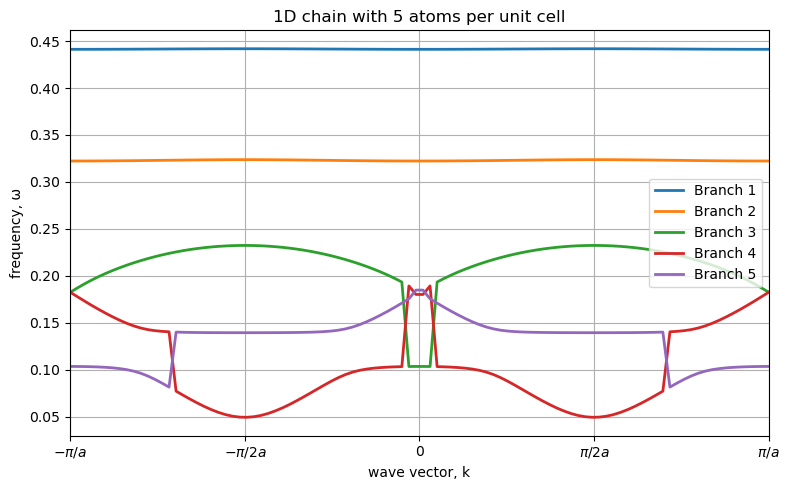

In [30]:
if __name__ == "__main__":
    #N_atomic_symbolic()
    k_vals, omega_vals = N_atomic_numeric(C=1.0, a=2.0, kpoints=100)
    plot_phonon_branches(k_vals, omega_vals, a=2.0)
    


Sucessfully plots N-atomic bands!

Need to include brief sections for single and diatomic systems without periodicity with basic animations